# Introduction
“Why is the sky blue?”

This is a question an open-domain question answering (QA) system should be able to respond to. QA systems emulate how people look for information by reading the web to return answers to common questions. Machine learning can be used to improve the accuracy of these answers.

Existing natural language models have been focused on extracting answers from a short paragraph rather than reading an entire page of content for proper context. As a result, the responses can be complicated or lengthy. A good answer will be both succinct and relevant.

In this competition, your goal is to predict short and long answer responses to real questions about Wikipedia articles. The dataset is provided by Google's Natural Questions, but contains its own unique private test set. A visualization of examples shows long and—where available—short answers. In addition to prizes for the top teams, there is a special set of awards for using TensorFlow 2.0 APIs.

If successful, this challenge will help spur the development of more effective and robust QA systems.

# Data Description
In this competition, we are tasked with selecting the best short and long answers from Wikipedia articles to the given questions.

# What should I expect the data format to be?
Each sample contains a Wikipedia article, a related question, and the candidate long form answers. The training examples also provide the correct long and short form answer or answers for the sample, if any exist.

# What am I predicting?
For each article + question pair, you must predict / select long and short form answers to the question drawn directly from the article. - A long answer would be a longer section of text that answers the question - several sentences or a paragraph. - A short answer might be a sentence or phrase, or even in some cases a YES/NO. The short answers are always contained within / a subset of one of the plausible long answers. - A given article can (and very often will) allow for both long and short answers, depending on the question.

There is more detail about the data and what you're predicting on the Github page for the Natural Questions dataset. This page also contains helpful utilities and scripts. Note that we are using the simplified text version of the data - most of the HTML tags have been removed, and only those necessary to break up paragraphs / sections are included.

# File descriptions
- simplified-nq-train.jsonl - the training data, in newline-delimited JSON format.
- simplified-nq-kaggle-test.jsonl - the test data, in newline-delimited JSON format.
- sample_submission.csv - a sample submission file in the correct format

# Data fields
- document_text - the text of the article in question (with some HTML tags to provide document structure). The text can be tokenized by splitting on whitespace.
- question_text - the question to be answered
- long_answer_candidates - a JSON array containing all of the plausible long answers.
- annotations - a JSON array containing all of the correct long + short answers. Only provided for train.
- document_url - the URL for the full article. Provided for informational purposes only. This is NOT the simplified version of the article so indices from this cannot be used directly. The content may also no longer match the html used to generate document_text. Only provided for train.
- example_id - unique ID for the sample.

# Submission File
For each ID in the test set, you must predict a) a set of start:end token indices, b) a YES/NO answer if applicable (short answers ONLY), or c) a BLANK answer if no prediction can be made. The file should contain a header and have the following format:

* -7853356005143141653_long,6:18
* -7853356005143141653_short,YES
* -545833482873225036_long,105:200
* -545833482873225036_short,
* -6998273848279890840_long,
* -6998273848279890840_short,NO

Interesting :).

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import gc
import json
import subprocess

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import seaborn as sns


# 1. Loading Data 

In [2]:
DIR = '../input/tensorflow2-question-answering/'
train_path = DIR + 'simplified-nq-train.jsonl'
test_path = DIR + 'simplified-nq-test.jsonl'

## Train Data

We can't load all the train data at once

In [3]:
N_TRAIN =0
with open(train_path, 'rt') as f:
    while(f.readline()):
        N_TRAIN +=1
print("Number OF Train Samples: {}".format(N_TRAIN))

Number OF Train Samples: 307373


In [4]:
train_samples = []
N_HEAD = 10000

with open(train_path, 'rt') as f:
    for i in range(N_HEAD):
        train_samples.append(json.loads(f.readline()))
train_samples = pd.DataFrame(train_samples)
train_samples.head()

,document_text,long_answer_candidates,question_text,annotations,document_url,example_id
0,Email marketing - Wikipedia <H1> Email marketi...,"[{'start_token': 14, 'top_level': True, 'end_t...",which is the most common use of opt-in e-mail ...,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Em...,5655493461695504401
1,The Mother ( How I Met Your Mother ) - wikiped...,"[{'start_token': 28, 'top_level': True, 'end_t...",how i.met your mother who is the mother,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Th...,5328212470870865242
2,Human fertilization - wikipedia <H1> Human fer...,"[{'start_token': 14, 'top_level': True, 'end_t...",what type of fertilisation takes place in humans,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Hu...,4435104480114867852
3,List of National Football League career quarte...,"[{'start_token': 28, 'top_level': True, 'end_t...",who had the most wins in the nfl,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Li...,5289242154789678439
4,Roanoke Colony - wikipedia <H1> Roanoke Colony...,"[{'start_token': 32, 'top_level': True, 'end_t...",what happened to the lost settlement of roanoke,"[{'yes_no_answer': 'NONE', 'long_answer': {'st...",https://en.wikipedia.org//w/index.php?title=Ro...,5489863933082811018


## Test Data

Since, the test data sin't large file,  we can load the test data pandas read_read_jsonl <br>
refer [this](https://datatofish.com/load-json-pandas-dataframe/)

In [5]:
df_test = pd.read_json(test_path, orient='records', lines=True, dtype={'example_id':np.dtype('object')})

In [6]:
N_TEST = df_test.shape[0]
N_TEST

346

In [7]:
df_test.head()

,example_id,question_text,document_text,long_answer_candidates
0,-1220107454853145579,who is the south african high commissioner in ...,"High Commission of South Africa , London - wik...","[{'end_token': 136, 'start_token': 18, 'top_le..."
1,8777415633185303067,the office episode when they sing to michael,Michael 's Last Dundies - wikipedia <H1> Micha...,"[{'end_token': 190, 'start_token': 23, 'top_le..."
2,4640548859154538040,what is the main idea of the cross of gold speech,Cross of gold speech - wikipedia <H1> Cross of...,"[{'end_token': 165, 'start_token': 12, 'top_le..."
3,-5316095317154496261,when was i want to sing in opera written,Wilkie Bard - wikipedia <H1> Wilkie Bard </H1>...,"[{'end_token': 105, 'start_token': 8, 'top_lev..."
4,-8752372642178983917,who does the voices in ice age collision course,Ice Age : Collision Course - Wikipedia <H1> Ic...,"[{'end_token': 287, 'start_token': 16, 'top_le..."


# 2. Data Understanding

## Missing Value

In [9]:
df = pd.DataFrame(train_samples.isnull().sum()).reset_index()
df.columns = ['features', 'n_missing_values']
df

,features,n_missing_values
0,document_text,0
1,long_answer_candidates,0
2,question_text,0
3,annotations,0
4,document_url,0
5,example_id,0


In [10]:
df = pd.DataFrame(df_test.isnull().sum()).reset_index()
df.columns = ['features', 'n_missing_values']
df

,features,n_missing_values
0,example_id,0
1,question_text,0
2,document_text,0
3,long_answer_candidates,0


        We don't have missing value yet
        NOTE:- We just loaded a sample of train data in which we found no missing value, but there can be some missing value in the orignal train data. But in the test data there isn't any missing value

### Question Text

In [11]:
index = 0
question = train_samples.iloc[index,]['question_text']
question

'which is the most common use of opt-in e-mail marketing'

### Document Text

In [12]:
document_text = train_samples.iloc[index]['document_text'].split()
print(len(document_text))
" ".join(document_text[:200])

3778


'Email marketing - Wikipedia <H1> Email marketing </H1> Jump to : navigation , search <Table> <Tr> <Td> </Td> <Td> ( hide ) This article has multiple issues . Please help improve it or discuss these issues on the talk page . ( Learn how and when to remove these template messages ) <Table> <Tr> <Td> </Td> <Td> This article needs additional citations for verification . Please help improve this article by adding citations to reliable sources . Unsourced material may be challenged and removed . ( September 2014 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <Td> </Td> <Td> This article possibly contains original research . Please improve it by verifying the claims made and adding inline citations . Statements consisting only of original research should be removed . ( January 2015 ) ( Learn how and when to remove this template message ) </Td> </Tr> </Table> ( Learn how and when to remove this template message ) </Td> </Tr> </Table> <Table> <Tr> <T

Document text is a huge wikipedia article

### Long answer candidate

In [13]:
long_answer_candidates = train_samples.iloc[index]['long_answer_candidates']
print(len(long_answer_candidates))
long_answer_candidates[0:10]

63


[{'start_token': 14, 'top_level': True, 'end_token': 170},
 {'start_token': 15, 'top_level': False, 'end_token': 169},
 {'start_token': 52, 'top_level': False, 'end_token': 103},
 {'start_token': 53, 'top_level': False, 'end_token': 102},
 {'start_token': 103, 'top_level': False, 'end_token': 156},
 {'start_token': 104, 'top_level': False, 'end_token': 155},
 {'start_token': 170, 'top_level': True, 'end_token': 321},
 {'start_token': 171, 'top_level': False, 'end_token': 180},
 {'start_token': 180, 'top_level': False, 'end_token': 186},
 {'start_token': 186, 'top_level': False, 'end_token': 224}]

This are all the possibles long answers ranges. <br>
In other words they give you the start indices and last indices of all the possibles long answers in the document text columns that could answer the question.

### Annotation

In [14]:
annotations = train_samples.iloc[index]['annotations'][0]
annotations

{'yes_no_answer': 'NONE',
 'long_answer': {'start_token': 1952,
  'candidate_index': 54,
  'end_token': 2019},
 'short_answers': [{'start_token': 1960, 'end_token': 1969}],
 'annotation_id': 593165450220027640}

* This is telling us that our long answer starts in indices 1952 and end at indices 2019.
* Also, we have a short answer that starts at indices 1960 and end at indices 1969.
* In this example we dont have a yes or no answer

### Submission file

In [15]:
sample_submission = pd.read_csv('/kaggle/input/tensorflow2-question-answering/sample_submission.csv')
print('Our sample submission have {} rows'.format(sample_submission.shape[0]))
sample_submission.head()

Our sample submission have 692 rows


,example_id,PredictionString
0,-1011141123527297803_long,NaN
1,-1011141123527297803_short,NaN
2,-1028916936938579349_long,NaN
3,-1028916936938579349_short,NaN
4,-1055197305756217938_long,NaN



* If you check the submission file we have 692 rows, this means that for each row in the test set we have to predict the short and long answer
* Sometime long and short answer are not available, in this case it's possible that we have a Yes or No answer for the short answer.

In [16]:
print('Our question is : ', question)
print('Our short answer is : ', " ".join(document_text[annotations['short_answers'][0]['start_token']:annotations['short_answers'][0]['end_token']]))
print('Our long answer is : ', " ".join(document_text[annotations['long_answer']['start_token']:annotations['long_answer']['end_token']]))

Our question is :  which is the most common use of opt-in e-mail marketing
Our short answer is :  a newsletter sent to an advertising firm 's customers
Our long answer is :  <P> A common example of permission marketing is a newsletter sent to an advertising firm 's customers . Such newsletters inform customers of upcoming events or promotions , or new products . In this type of advertising , a company that wants to send a newsletter to their customers may ask them at the point of purchase if they would like to receive the newsletter . </P>


# 3. Data Visualization

## 3.1 Visualization of short, long and yes/no answers

## Visualization funcition to be used

In [129]:
def bar_plot(df, title = 'Distribution of Target'):
    """
    Plot seaBorn Count plot for a given 1 dimensional Data
    Parameters:
        df: 1 Dimensional Pandas seris/dataFrame
        title: Title of the plot in string format

    Returns:
        void
    """
    import seaborn as sns
    plt.figure(figsize=(8, 8))
    sns.barplot(x=df.value_counts().index, y=(df.value_counts().values)/len(df))
    plt.title(title)
    plt.show()
    print(df.value_counts())
    return 

# this function extract the short answers and fill a dataframe
def extract_short_answer(df):
    """
    This Funtion extracts the short answer from the dataFrame
    Parameters:
        df: 1 Dimensional Pandas seris/dataFrame
        

    Returns:
        short_answer: token converted short answer from the data
    """
    short_answer = []
    for i in range(len(df)):
        short = df.iloc[i]['annotations'][0]['short_answers']
        if short == []:
            yes_no = df['annotations'][i][0]['yes_no_answer']
            if yes_no == 'NO' or yes_no == 'YES':
                short_answer.append(yes_no)
            else:
                short_answer.append('EMPTY')
        else:
            short = short[0]
            st = short['start_token']
            et = short['end_token']
            short_answer.append(f'{st}'+':'+f'{et}')
    short_answer = pd.DataFrame({'short_answer': short_answer})
    return short_answer

def extract_long_answer(df):
    """
    This Funtion extracts the long answer from the dataFrame
    Parameters:
        df: 1 Dimensional Pandas seris/dataFrame
        

    Returns:
        long_answer: token converted long answer from the data
    """
    long_answer = []
    for i in range(len(df)):
        long = df.iloc[i]['annotations'][0]['long_answer']
        if long['start_token'] == -1:
            long_answer.append('EMPTY')
        else:
            st = long['start_token']
            et = long['end_token']
            long_answer.append(f'{st}'+':'+f'{et}')
    long_answer = pd.DataFrame({'long_answer': long_answer})
    return long_answer

def print_bar_plot_answers(df, answer = 'short'):
    """
    Print The count Plot for the type of short/long answer, i.e NONE, YES, NO or TEXT
    parameters: 
        df: Short/Long Answers in tokens 
        answer: to specify if the plot is done to be for the short answers or the long answers
        
    Returns:
        void
    """
    df_2 = pd.DataFrame()
    if answer == 'short':
        title = 'Distribution of short Answer'
        df_2['type'] = df['short_answer'].copy()
    if answer == 'long':
        title = 'Distribution of long Answer'
        df_2['type'] = df['long_answer'].copy()
    for i in range(len(df)):
        if df_2.iloc[i]['type'] == 'EMPTY' or df_2.iloc[i]['type'] == 'YES' or df_2.iloc[i]['type'] == 'NO':
            continue
        else:
            df_2.iloc[i]['type'] = 'TEXT'    
    bar_plot(df_2['type'], title)

def count_word_frequency(df, top = 20):
    """
    Plot the top word frequency the text data(question text, document text).
    Parameters:
        df: Question_text/Document_text
        top: how many top words to print.
    
    Returns: 
        void
    """
    
    import seaborn as sns
    from sklearn.feature_extraction.text import CountVectorizer
    
    print("Count Plot of top {} words".format(top))
    count_vec = CountVectorizer()   
    count_vec.fit(df)
    df_ = count_vec.transform(df)
    count_list = df_.toarray().sum(axis=0)
    vocab = count_vec.get_feature_names()
    
    df_2 = pd.DataFrame({'Word': vocab, 'Frequency': count_list})
    df_2.sort_values(['Frequency'], ascending = False, inplace = True)
    df_2['Percentage'] = (df_2['Frequency']/df_2['Frequency'].sum()).round(3)
    x = df_2.iloc[:top]
    plt.figure(figsize=(14, 14))
    #(df.value_counts().values)/len(df)
    sns.barplot(x=x['Word'], y=x['Percentage'].apply(lambda x: x*100))
    plt.title("Percentage Plot")
    plt.show()  

### 3.1.1 Yes_no Short answer

In [17]:
yes_no_answer = []
for i in range(len(train_samples)):
    yes_no_answer.append(train_samples.iloc[i]['annotations'][0]['yes_no_answer'])
yes_no_answer = pd.DataFrame({'yes_no_answer': yes_no_answer})
yes_no_answer    

,yes_no_answer
0,NONE
1,NONE
2,NONE
3,NONE
4,NONE
...,...
9995,NONE
9996,NONE
9997,NONE
9998,NONE


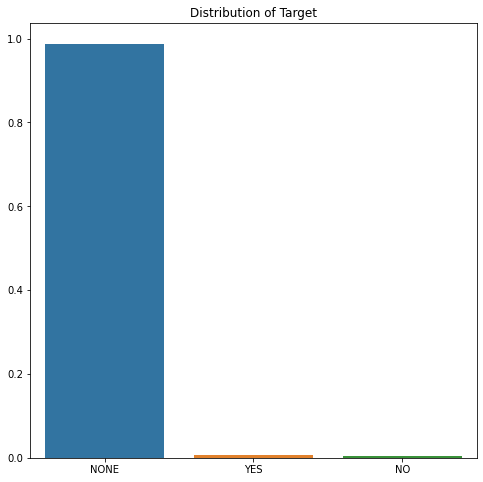

NONE    9878
YES       73
NO        49
Name: yes_no_answer, dtype: int64


In [19]:
bar_plot(yes_no_answer['yes_no_answer'])

### 3.1.2 Extract the answers from the dataset

In [ ]:
short_answer = extract_short_answer(train_samples)
long_answer = extract_long_answer(train_samples)

In [21]:
print(short_answer.sample(5))
print()
print(long_answer.sample(5))

     short_answer
2646      221:242
1085        EMPTY
408           YES
9699      337:338
6999        EMPTY

     long_answer
4444       EMPTY
7470       EMPTY
8274     156:208
2451   2277:2361
1775     215:357


### 3.1.3 Plot for the Short Answers

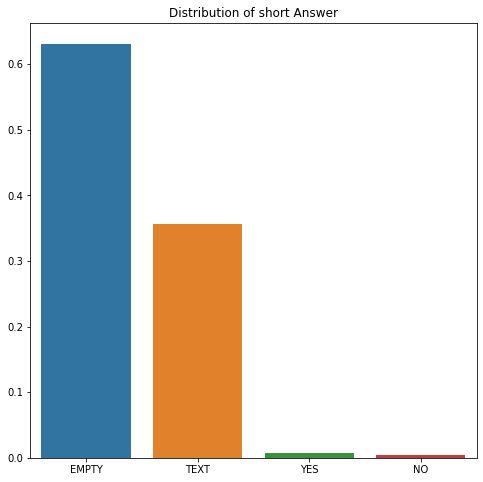

EMPTY    6312
TEXT     3566
YES        73
NO         49
Name: type, dtype: int64


In [23]:
print_bar_plot_answers(short_answer)

### Short Answer Results
- We have ~63% of the observations with a empty text
- We have ~35% of the observations with a start and end token result
- We have the same distribution for YES and NO 

### 3.1.4 Plot for the long answers

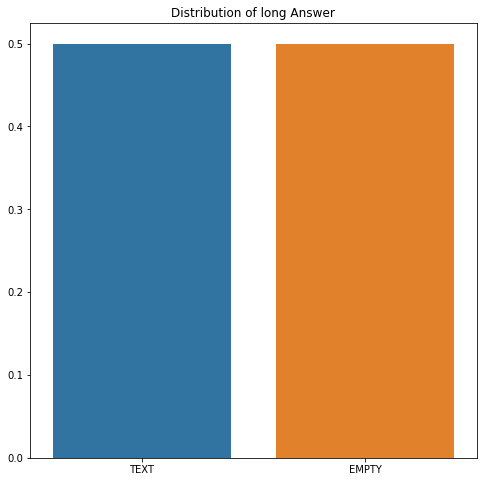

TEXT     5000
EMPTY    5000
Name: type, dtype: int64


In [24]:
print_bar_plot_answers(long_answer, 'long')

### Long Answer Results
- We have almost equal distribution of text and the empty cells.
- nearly half of the long answers have start/end token -1. In other words, there are a considerable number of 'NO ANSWERS' in long answer labels, not only in yes-no labels:

## 3.2 long_candidates_candidates

### 3.2.1 Plot for Long Answer Candidates count for each question

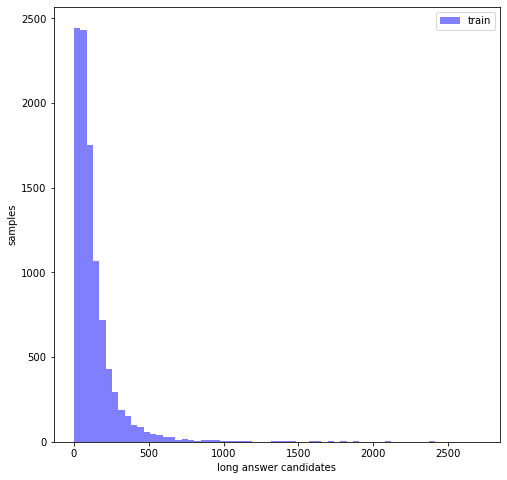

In [127]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
plt.figure(figsize=(8,8))
plt.hist(train_samples['long_answer_candidates'].apply(lambda x: len(x)), bins=64, alpha=0.5, color='b', label='train') 
plt.xlabel('long answer candidates')
plt.ylabel('samples')
plt.legend()
plt.show()

### 3.2.2 Plot for Long Answer Candidates count for each question for test data

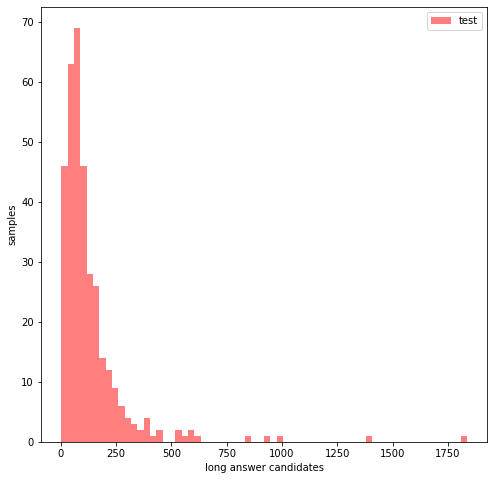

In [128]:
plt.figure(figsize=(8,8))
plt.hist(df_test['long_answer_candidates'].apply(lambda x: len(x)), bins=64, alpha=0.5, color='r', label='test')
plt.xlabel('long answer candidates')
plt.ylabel('samples')
plt.legend()
plt.show()

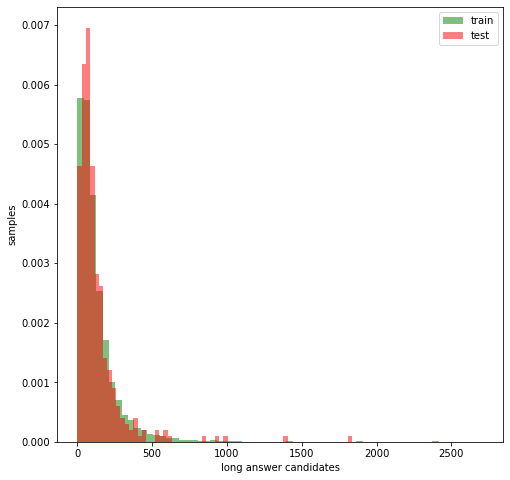

In [45]:
plt.figure(figsize=(8,8))
plt.hist(train_samples['long_answer_candidates'].apply(lambda x: len(x)), density = True, bins=64, alpha=0.5, color='g', label='train') 
plt.hist(df_test['long_answer_candidates'].apply(lambda x: len(x)), density = True, bins=64, alpha=0.5, color='r', label='test') 
plt.xlabel('long answer candidates')
plt.ylabel('samples')
plt.legend()
plt.show()

## 3.3 Question Visualization

In [130]:
question = train_samples['question_text']
text = train_samples['document_text']

### 3.3.1 Word count plot for question

Question Word Count Plot


[]

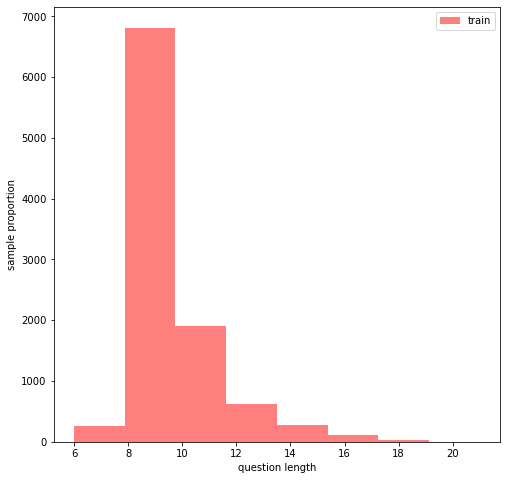

In [132]:
print("Question Word Count Plot")
plt.figure(figsize=(8,8))
plt.hist(question.apply(lambda x: len(x.split())), bins=8, alpha=0.5, color='r', label='train') 
plt.xlabel('question length')
plt.ylabel('sample proportion')
plt.legend()
plt.plot()

- Question length vary from ~(6, 20) and maximum question have its length in the range of ~(8, 12)

### 3.3.2 Word count plot for document_text

Document Text Word Count Plot


[]

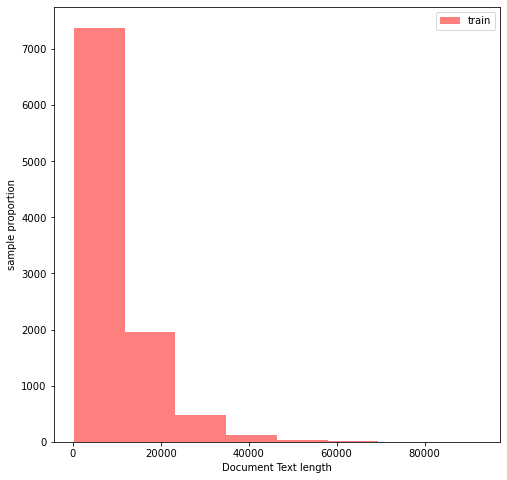

In [134]:
print("Document Text Word Count Plot")
plt.figure(figsize=(8,8))
plt.hist(text.apply(lambda x: len(x.split())), bins=8, alpha=0.5, color='r', label='train') 
plt.xlabel('Document Text length')
plt.ylabel('sample proportion')
plt.legend()
plt.plot()

- Range of length of document text is ~(50, 40000)
- Range of text length in which maximum document lie ~(100, 10000)

## 3.4 Top Words Frequency

### 3.4.1 Top Words Frequency for Question 

Count Plot of top 20 words


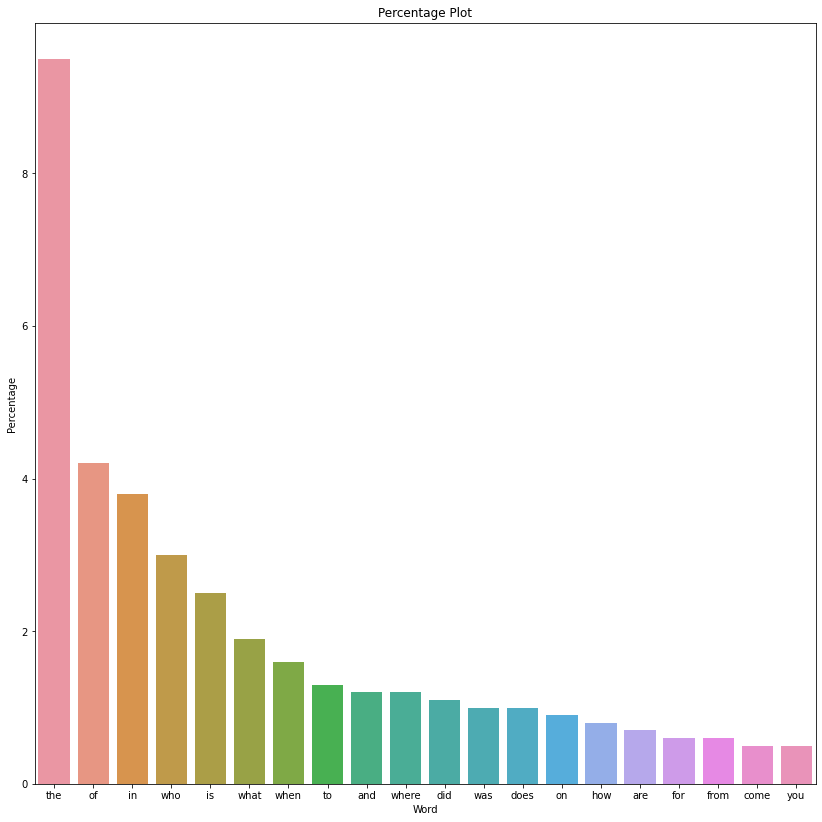

In [121]:
count_word_frequency(train_samples['question_text'], 20)

### 3.4.2 Top Words Frequency for Document text

Count Plot of top 20 words


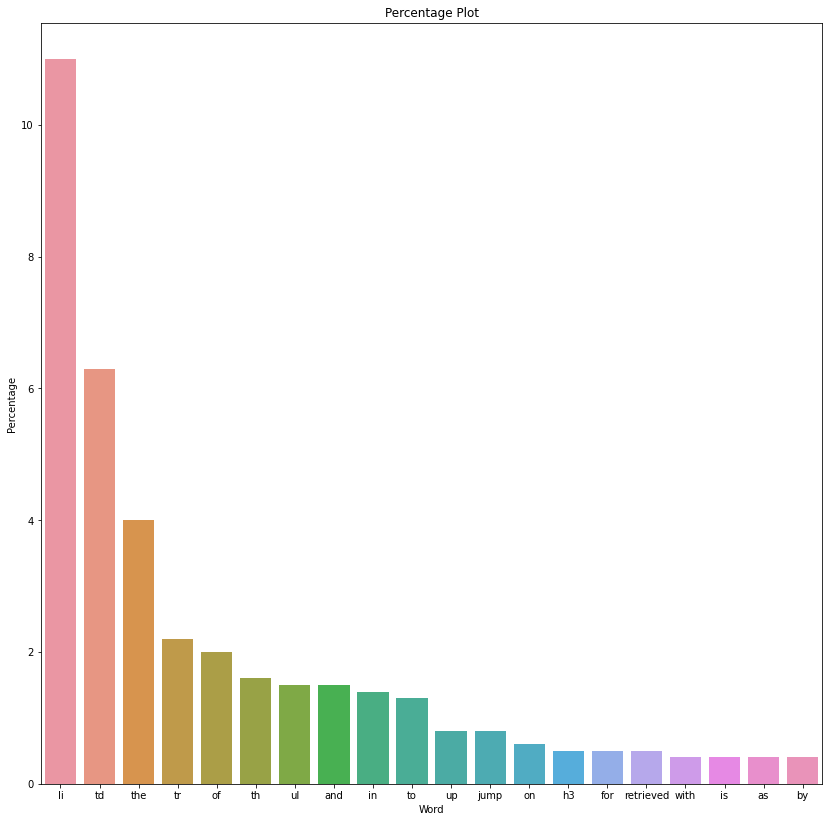

In [105]:
count_word_frequency(df_test['document_text'], 20)